In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Given Inputs
temp = 298 #Kelvin
pres = 1e5 #Pascals
Rgas = 8.314 #J/(mol-K)
avo = 6.022e23 

PHOx = 0.1 #pptv/s

In [3]:
#rate constants, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 #units s-1
k8 = 1.9e-14

In [4]:
#unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #molecules
CPHOx = PHOx*1e-12*airden #molecule/cm3-s
ppbfac = 1e9/airden

In [5]:
def myconc (nox, rh):
    Cnox = nox*1e-9*airden
    Crh = rh*1e-9*airden
    u0 = np.zeros(7)
    u0[0] = Cnox*(2/3)
    u0[1] = Cnox*(1/3)
    u0[2] = 0
    u0[3] = 0
    u0[4] = 0
    u0[5] = 0
    u0[6] = Crh
    sol = solve_ivp(myfun, [t0, tmax], u0, method='LSODA', dense_output=True)
    return np.max(sol.y[5]) * ppbfac

In [6]:
# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH
def myfun(t,u):
    f = np.zeros(7)
    f[0] = -k2*u[3]*u[0] + k7*u[1] - k8*u[5]*u[0] - k3*u[4]*u[0]
    f[1] = k2*u[3]*u[0] + k3*u[4]*u[0] + k8*u[5]*u[0] - k7*u[1] - k4*u[2]*u[1]
    f[2] = -k1*u[6]*u[2] + k3*u[4]*u[0] - k4*u[2]*u[1] + CPHOx 
    f[3] = k1*u[6]*u[2] - k2*u[3]*u[0] - k6*u[3]*u[4]
    f[4] = k2*u[3]*u[0] - k3*u[4]*u[0] - 2*k5*u[4]**2 - k6*u[3]*u[4]
    f[5] = k7*u[1] - k8*u[5]*u[0]
    f[6] = -k1*u[6]*u[2]
    return f

In [7]:
#timestep
Dt = 2 #seconds
t0 = 0
tmax = 96*3600
t = np.arange(t0, t0+tmax, Dt)
NN = np.shape(t)
N = NN[0]

In [8]:
input_nox = np.arange(0,50,1)
input_rh = np.arange(50,500,9)
sol_max = np.zeros((50,50))

for i, nox in enumerate(input_nox):
    for j, rh in enumerate(input_rh):
        sol_max[i,j] = myconc(nox, rh)
sol_max

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 91.9080408 , 107.5738435 , 123.00675183, ..., 317.96665522,
        318.30759226, 318.63457992],
       [ 95.41765398, 112.13098485, 128.67755126, ..., 450.18725921,
        450.73180064, 451.46752023],
       ...,
       [ 72.09725394,  88.99267669, 106.15849767, ..., 870.96712166,
        886.93510005, 902.78114608],
       [ 71.56310587,  88.4167147 , 105.47794561, ..., 866.14714304,
        882.05070287, 898.00080431],
       [ 71.04388553,  87.82417792, 104.78514411, ..., 861.27493209,
        877.31503844, 892.96794159]])

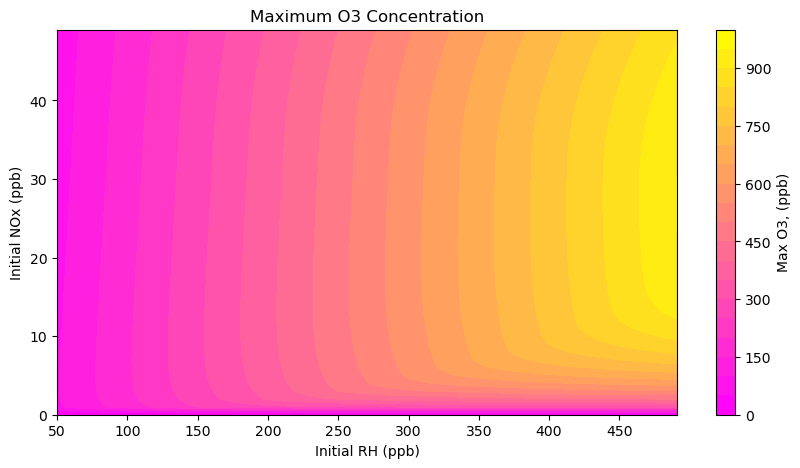

In [9]:
plt.figure(figsize=(10,5))
cp = plt.contourf(input_rh, input_nox, sol_max, cmap="spring", levels=20)
plt.colorbar(cp, label='Max O3, (ppb)')
plt.xlabel('Initial RH (ppb)')
plt.ylabel('Initial NOx (ppb)')
plt.title('Maximum O3 Concentration')
plt.show()